# K-Means 101
I've been working a lot with the Museum of Modern Art's collection dataset recently and thought it would be useful to cluster paintings based on size.

One approach would be to use `pandas.cut()` or `pandas.qcut()` to choose cutoff points for `small`, `medium`, and `large` works, but this would require choosing only one of the size features that we have: either `Width (cm)`, `Height (cm)`, or my engineered feature of `Area (cm sq)`. Perhaps using `Area (cm sq)` would give us a good approximation, but there's another problem: how many segments do we want? Here I suggested three--small, medium, and large--but this decision is somewhat arbitrary. Why not 4? 5? More?

An alternative approach is to use a clustering algorithm to cluster the data based on all three size features, and then using the 'elbow method' to find the optimal number of clusters. That's what I'll do here.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('../data/moma/Artworks_multiartist_clean.csv')
df

,Title,Artist,ConstituentID,ArtistBio,Nationality,BeginDate,EndDate,Gender,Date,Medium,...,year_acquired,date_stripped,begun_year,completed_year,birth_year,death_year,artwork_age,living,artist_age,years_posthumous
0,"Ferdinandsbrücke Project, Vienna, Austria (Ele...",Otto Wagner,6210,"(Austrian, 1841–1918)",(Austrian),(1841),(1918),(Male),1896,Ink and cut-and-pasted painted pages on paper,...,1996.0,1896,1896.0,1896.0,1841.0,1918.0,100.0,0.0,NaN,78.0
1,"City of Music, National Superior Conservatory ...",Christian de Portzamparc,7470,"(French, born 1944)",(French),(1944),(0),(Male),1987,Paint and colored pencil on print,...,1995.0,1987,1987.0,1987.0,1944.0,0.0,8.0,1.0,51.0,NaN
2,"Villa near Vienna Project, Outside Vienna, Aus...",Emil Hoppe,7605,"(Austrian, 1876–1957)",(Austrian),(1876),(1957),(Male),1903,"Graphite, pen, color pencil, ink, and gouache ...",...,1997.0,1903,1903.0,1903.0,1876.0,1957.0,94.0,0.0,NaN,40.0
3,"The Manhattan Transcripts Project, New York, N...",Bernard Tschumi,7056,"(French and Swiss, born Switzerland 1944)",(),(1944),(0),(Male),1980,Photographic reproduction with colored synthet...,...,1995.0,1980,1980.0,1980.0,1944.0,0.0,15.0,1.0,51.0,NaN
4,"Villa, project, outside Vienna, Austria, Exter...",Emil Hoppe,7605,"(Austrian, 1876–1957)",(Austrian),(1876),(1957),(Male),1903,"Graphite, color pencil, ink, and gouache on tr...",...,1997.0,1903,1903.0,1903.0,1876.0,1957.0,94.0,0.0,NaN,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141576,"Page from Sketchbook #24, New York City",Ellsworth Kelly,3048,"(American, 1923–2015)",(American),(1923),(2015),(Male),1954-55,Page from a spiral-bound sketchbook with penci...,...,2020.0,1954-55,1954.0,1955.0,1923.0,2015.0,65.0,0.0,NaN,5.0
141577,"Page from Sketchbook #24, New York City",Ellsworth Kelly,3048,"(American, 1923–2015)",(American),(1923),(2015),(Male),1954-55,Page from a spiral-bound sketchbook with penci...,...,2020.0,1954-55,1954.0,1955.0,1923.0,2015.0,65.0,0.0,NaN,5.0
141578,"Page from Sketchbook #24, New York City",Ellsworth Kelly,3048,"(American, 1923–2015)",(American),(1923),(2015),(Male),1954-55,Page from a spiral-bound sketchbook with penci...,...,2020.0,1954-55,1954.0,1955.0,1923.0,2015.0,65.0,0.0,NaN,5.0
141579,"Front cover of Sketchbook #24, New York City",Ellsworth Kelly,3048,"(American, 1923–2015)",(American),(1923),(2015),(Male),1954-55,"Spiral-bound sketchbook with pencil, ballpoint...",...,2020.0,1954-55,1954.0,1955.0,1923.0,2015.0,65.0,0.0,NaN,5.0


In [3]:
# Isolate paintings
paintings = df[df['Classification'] == 'Painting'].copy(deep=True)

paintings.head()

,Title,Artist,ConstituentID,ArtistBio,Nationality,BeginDate,EndDate,Gender,Date,Medium,...,year_acquired,date_stripped,begun_year,completed_year,birth_year,death_year,artwork_age,living,artist_age,years_posthumous
32097,"Rope and People, I",Joan Miró,4016,"(Spanish, 1893–1983)",(Spanish),(1893),(1983),(Male),"Barcelona, March 27, 1935","Oil on cardboard mounted on wood, with coil of...",...,1936.0,1935,1935.0,1935.0,1893.0,1983.0,1.0,1.0,43.0,NaN
33171,Fire in the Evening,Paul Klee,3130,"(German, born Switzerland. 1879–1940)",(German),(1879),(1940),(Male),1929,Oil on cardboard,...,1970.0,1929,1929.0,1929.0,1879.0,1940.0,41.0,0.0,NaN,30.0
33428,Portrait of an Equilibrist,Paul Klee,3130,"(German, born Switzerland. 1879–1940)",(German),(1879),(1940),(Male),1927,Oil and collage on cardboard over wood with pa...,...,1966.0,1927,1927.0,1927.0,1879.0,1940.0,39.0,0.0,NaN,26.0
34488,Guitar,Pablo Picasso,4609,"(Spanish, 1881–1973)",(Spanish),(1881),(1973),(Male),"Paris, early 1919","Oil, charcoal and pinned paper on canvas",...,1955.0,1919,1919.0,1919.0,1881.0,1973.0,36.0,1.0,74.0,NaN
35406,Grandmother,Arthur Dove,1602,"(American, 1880–1946)",(American),(1880),(1946),(Male),1925,"Shingles, needlepoint, page from Concordance, ...",...,1939.0,1925,1925.0,1925.0,1880.0,1946.0,14.0,1.0,59.0,NaN


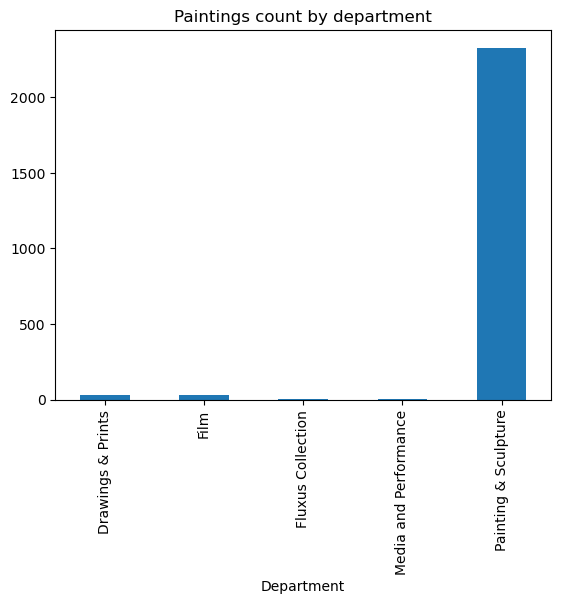

In [4]:
# Out of curiosity, what departments are paintings in?
paintings.groupby('Department')['Title'].count().plot(kind='bar')

plt.title('Paintings count by department');

# A Brief Overview of the Data
Before proceeding, let's check in with the dataset and remind ourself what the size features look like.

In [5]:
# Replace Width/Height of 0 with NaN
paintings.loc[paintings['Width (cm)'] == 0, 'Width (cm)'] = np.nan
paintings.loc[paintings['Height (cm)'] == 0, 'Height (cm)'] = np.nan

# Drop works with missing height and/or width
paintings = paintings.dropna(subset=['Width (cm)', 'Height (cm)'])

paintings['Area (cm sq)'] = paintings['Width (cm)'] * paintings['Height (cm)']
paintings['Area (cm sq)']

32097      7818.080000
33171      1125.540000
33428      2219.040000
34488     16991.330000
35406      2743.200000
              ...     
140409    15913.131826
140477    90812.721601
140560    72983.725000
140585     2580.650323
140592    14864.545858
Name: Area (cm sq), Length: 2352, dtype: float64

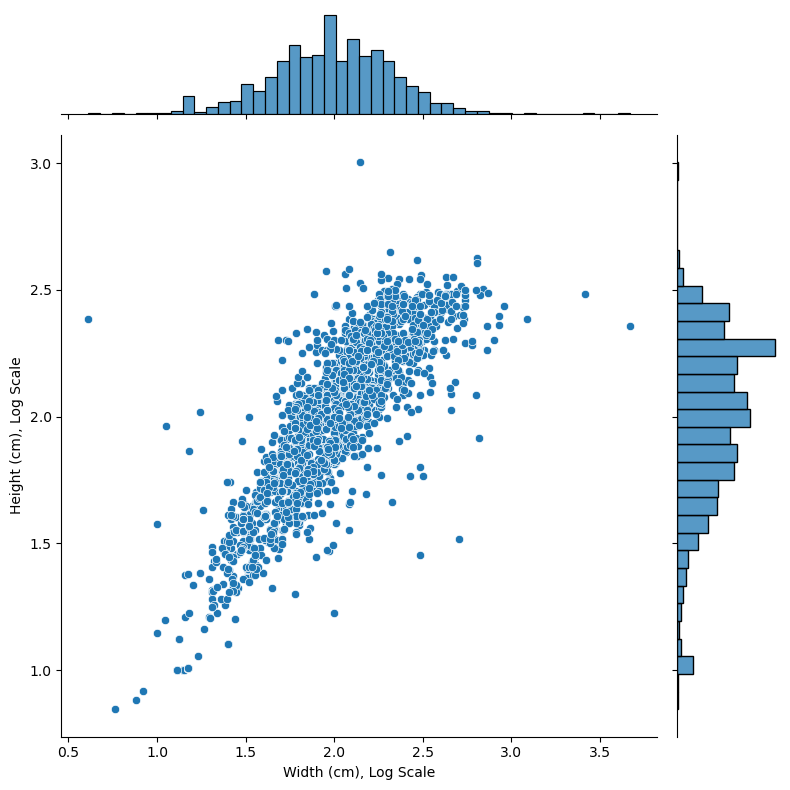

In [6]:
sns.jointplot(
    x=np.log10(paintings['Width (cm)']),
    y=np.log10(paintings['Height (cm)']),
    height=8
)

plt.xlabel('Width (cm), Log Scale')
plt.ylabel('Height (cm), Log Scale');

Here I'm just plotting height and width, of course. What we see is that painting size, when plotted on a logarithmic scale, forms a mostly continuous and normal distribution. Obviously we're missing the `Area (cm sq)` feature here, but judging by `Height (cm)` and `Width (cm)` it isn't really obvious how many clusters there ought to be, nor where their boundaries are.

This is where K-Means can help us.

# Using K-Means
Implementing K-Means is super easy. First I'm going to isolate the features of interest--`Width (cm)`, `Height (cm)`, and `Area (cm sq)`. Then I'll run the clustering algorithm multiple times with varying numbers of clusters.

In [7]:
X = np.log10(paintings[['Width (cm)', 'Height (cm)', 'Area (cm sq)']])

# Cluster trying k = 1-10
k_values = []
inertia_values = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    k_values.append(k)
    inertia_values.append(kmeans.inertia_)

If we plot the result, we can see the inertia score (lower is better) as a function of the number of clusters.

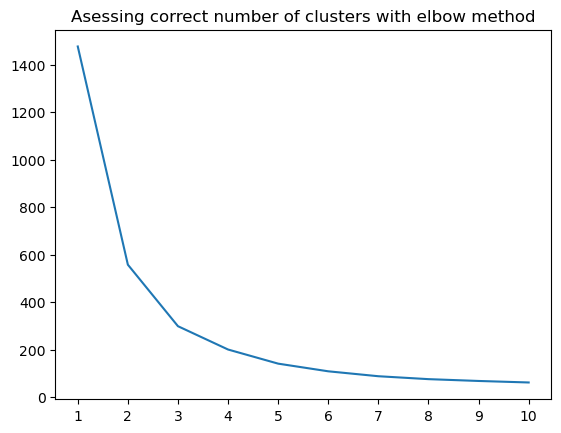

In [8]:
plt.plot(k_values, inertia_values)

plt.xticks(k_values)

plt.title("Asessing correct number of clusters with elbow method");

As to be expected, the fit improves as the number of clusters `k` increases, but the rate of improvement decreases substantially after `k = 3` clusters. Here's the 'elbow method' in action. Turns out 3 clusters--small, medium, and large--fits the data pretty well, so we'll stick with that.

# Visualizing the Result
Let's have another look at the scatter plot (again, just width and height features), but with our new clusters colod-coded.

In [9]:
# Fit with k=3 clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)

kmeans.inertia_

298.537557999254

In [10]:
paintings['size'] = kmeans.labels_
paintings['size'] = paintings['size'].map({0:'Small', 1:'Mediam', 2: 'Large'})

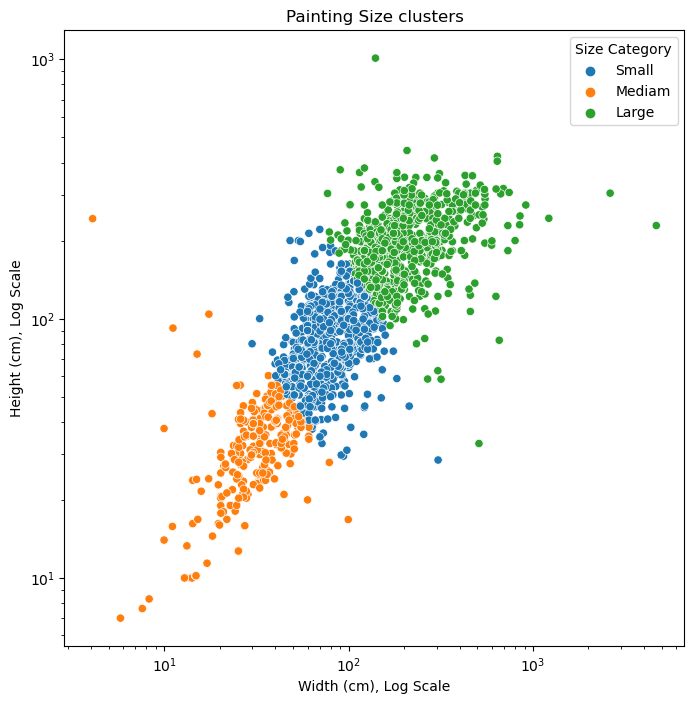

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(
    data=paintings,
    x='Width (cm)',
    y='Height (cm)',
    hue = 'size',
    ax=ax
)

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(title='Size Category')

ax.set_title('Painting Size clusters')
ax.set_xlabel('Width (cm), Log Scale')
ax.set_ylabel('Height (cm), Log Scale');

There you have it! Now we can use this new categorical feature that I've created to segment the data in new ways.